In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os


In [90]:
#!pip install datasets

from datasets import load_dataset

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Load the manga book classifier dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

# Save images to directories
def save_images(dataset, split, folder):
    os.makedirs(folder, exist_ok=True)
    for i, example in enumerate(dataset[split]):
        image = example['image']
        label = example['label']
        label_folder = os.path.join(folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        image.save(os.path.join(label_folder, f'image_{i}.jpg'))

# Access the splits using the correct keys ('train' and 'test' for this dataset)
save_images(dataset, 'train', 'dataset/train') # Ensure split key is 'train'
save_images(dataset, 'test', 'dataset/test')  # Ensure split key is 'test'

# Create validation set from training set
def split_train_data(train_dir, val_split=0.2):
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        images = os.listdir(label_dir)
        train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

        # Create validation directory
        val_label_dir = os.path.join('dataset/valid', label)
        os.makedirs(val_label_dir, exist_ok=True)

        # Move images to validation directory
        for image in val_images:
            os.rename(os.path.join(label_dir, image), os.path.join(val_label_dir, image))

# Split the training data into train/validation
split_train_data('dataset/train')

# Update directories
train_dir = 'dataset/train/'
valid_dir = 'dataset/valid/'
test_dir = 'dataset/test/'


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
PATH = 'dataset/' ## Specify your path here...
train_dataset = image_dataset_from_directory(
 PATH + "train", # Removed extra "train"
 image_size=(180, 180),
 batch_size=32)

validation_dataset = image_dataset_from_directory(
 PATH + "valid", # Changed "validation" to "valid" to match directory name
 image_size=(180, 180),
 batch_size=32)

Found 4094 files belonging to 4 classes.
Found 1026 files belonging to 4 classes.


In [ ]:
# Print class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Optionally, you can also print the number of classes
print("Number of Classes:", len(class_names))

Class Names: ['0', '1', '2', '3']
Number of Classes: 4


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
# Assuming these are the classes; update based on actual labels
class_names = {
    'Mild_Demented': 0,
    'Non_Dementeds': 1 ,# Assuming these are the classes; update based on actual labels
    'Very_Mild_Demented': 2,
    'Moderate_Demented': 3
}


In [ ]:
# Function to load dataset with custom labels
def load_dataset(directory, image_size=(180, 180), batch_size=32):
    dataset = image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        labels='inferred',  # Automatically infer labels from the folder structure
        label_mode='int'  # Integer labels
    )

    # Custom label mapping
    def map_labels(image, label):
        # Convert label from integer to custom label
        custom_label = tf.cast(tf.gather(tf.constant(list(class_names.values())), label), tf.int32)
        return image, custom_label

    dataset = dataset.map(map_labels)
    return dataset


In [ ]:

# Load datasets (ensure these directories are correct)
train_dataset = load_dataset('dataset/train/')
validation_dataset = load_dataset('dataset/valid/')
test_dataset = load_dataset('dataset/test/')

# Print class names and their labels
print("Class Names and their Labels:")
for class_name, label in class_names.items():
    print(f"{class_name}: {label}")

# Optionally, you can print the number of classes
print("Number of Classes:", len(class_names))

Found 4094 files belonging to 4 classes.
Found 1026 files belonging to 4 classes.
Found 1280 files belonging to 4 classes.
Class Names and their Labels:
Mild_Demented: 0
Non_Dementeds: 1
Very_Mild_Demented: 2
Moderate_Demented: 3
Number of Classes: 4


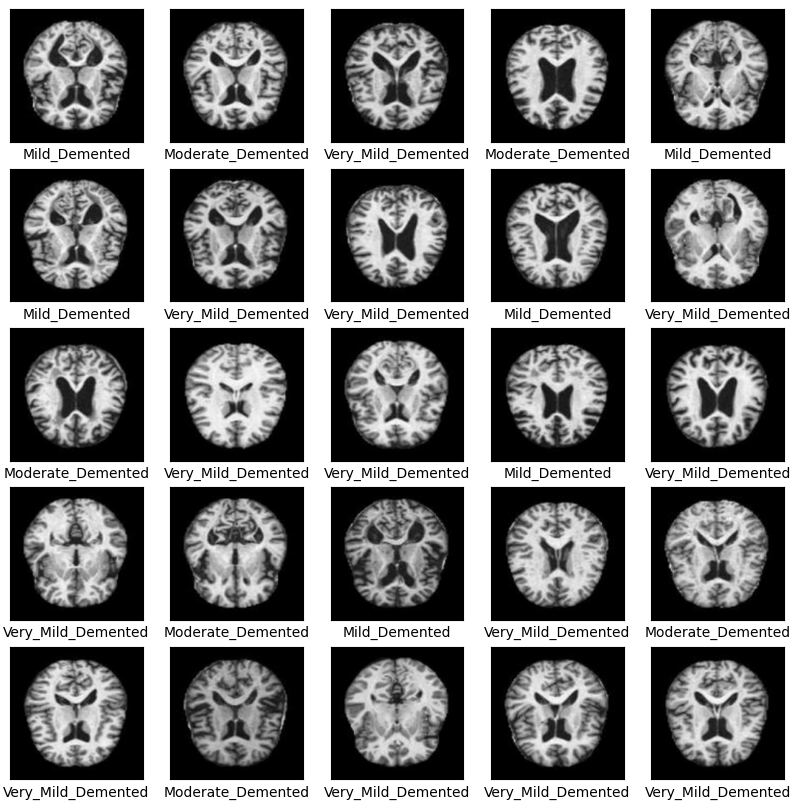

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Iterate over the dataset and take only the first 25 images and labels
for images, labels in train_dataset.take(1):  # Take only one batch
    num_images = min(25, images.shape[0])  # Limit the number of images to 25
    for i in range(num_images):  # Iterate over the first 25 images only
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        # Convert the label tensor to a NumPy integer
        label_index = labels[i].numpy()
        # Use the integer index to access the class name
        plt.xlabel(list(class_names.keys())[list(class_names.values()).index(label_index)])
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models # Import the models module

# Model building using Functional API
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalize pixel values
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │         204,804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,052 (1.14 MB)

 Trainable params: 298,052 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9649 - val_loss: 0.1534
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 1.0000 - loss: 5.3058e-04 - val_accuracy: 0.9678 - val_loss: 0.1533
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 1.0000 - loss: 3.9111e-04 - val_accuracy: 0.9678 - val_loss: 0.1528
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 1.0000 - loss: 2.9752e-04 - val_accuracy: 0.9669 - val_loss: 0.1545
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 1.0000 - loss: 2.4125e-04 - val_accuracy: 0.9669 - val_loss: 0.1559


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 567ms/step - accuracy: 0.9608 - loss: 0.2554
Test accuracy: 0.961
